# Importing Libraries

In [85]:
import argparse
import cv2
import numpy as np 
import pandas as pd
import os
from matplotlib import pyplot as plt
from skimage import io, data, exposure, morphology
from sklearn.cluster import KMeans

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS67_Fall2022_ A1_Dataset/

Mounted at /content/drive
/content/drive/My Drive/CS67_Fall2022_ A1_Dataset


# All functions

In [54]:
def Read_data():
  # All the data will be added in these lists
  test_data=[]
  train_data=[]
  #For iteration over all folders
  folders=['00001/','00002/','00003/','00004/','00005/','00006/','00007/','00008/','00009/','00010/']
  for i in folders:
    filename=i+'train.txt'
    #training text file in each folder is opened
    with open(filename) as f:
      lines = f.readlines()
      for j in lines:
        #Appending path and label
        #path=folder_name+image_name=i+j[:-1]
        #label=folder_name=i[:-1]
        train_data.append([i+j[:-1],i[:-1]])

    filename=i+'/test.txt'
    #testing text file in each folder is opened
    with open(filename) as f:
      lines = f.readlines()
      for j in lines:
        #same process repeated
        test_data.append([i+j[:-1],i[:-1]])

  #train data list converted to dataframe
  train_df = pd.DataFrame(train_data, columns =['Path', 'Label'])
  #test data list converted to dataframe
  test_df = pd.DataFrame(test_data,columns=['Path','Label'])
  
  return train_df,test_df

In [55]:
def show(img):
  #to show/plot and image
    io.imshow(img)
    plt.show()

In [56]:
def ORB_descriptor(df):
  descriptors=[]
  #ORB object
  ORB_object = cv2.ORB_create(fastThreshold=12, edgeThreshold=12)
  #iteration over each image path
  for path in df.Path:
    img = cv2.imread(path)
    #convert image ot grayscale
    input_image= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #detect the keypoint and descriptor
    keypoints = ORB_object.detect(input_image)
    keypoints, des = ORB_object.compute(input_image, keypoints)
    #each descriptor is separately added as a separate row
    for j in des:
      descriptors.append([j,path])

  #converted to a dataframe
  descriptors_df = pd.DataFrame(descriptors,columns=['Descriptor','Path'])
  return descriptors_df

In [57]:
def SIFT_descriptors(df):
  descriptors=[]
  #SIFT object
  sift = cv2.xfeatures2d.SIFT_create()
  #iteration over each image path
  for i in df.Path:
    img = cv2.imread(i)
    #image is converted to gray svale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #detect the keypoint and descriptor
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray_img, None)
    #each descriptor is separately added as a separate row
    for j in des:
      descriptors.append([j,i])

  #converted to a dataframe
  descriptors_df = pd.DataFrame(descriptors,columns=['Descriptor','Path'])
  return descriptors_df

In [58]:
def Stacking_descriptors(descriptors_df):
  #each row in decriptor column is stacked to the array
  descriptors_array=np.array(descriptors_df.Descriptor[0])
  for i in descriptors_df.Descriptor[1:]:
    descriptors_array=np.vstack((descriptors_array,i))

  return descriptors_array


In [59]:
def Get_descriptors(train_df,test_df):
  print('\nGetting Descriptors for SIFT...')
  #Getting SIFT descriptors for Train dataset
  print('Calculating training data descriptors...')
  train_descriptors_SIFT=SIFT_descriptors(train_df)

  #Stacking
  print('Stacking desciptors...')
  descriptors_array_SIFT=Stacking_descriptors(train_descriptors_SIFT)

  #Getting SIFT descriptors for Test dataset
  print('Calculating testing data descriptors...')
  test_descriptors_SIFT=SIFT_descriptors(test_df)
  
  print('\nGetting Descriptors for ORB...')
  #Getting ORB descriptors for Train dataset
  print('Calculating training data descriptors...')
  train_descriptors_ORB=ORB_descriptor(train_df)

  #Stacking train descriptor
  print('Stacking desciptors...')
  descriptors_array_ORB=Stacking_descriptors(train_descriptors_ORB)

  #Getting ORB descriptors for Test dataset
  print('Calculating testing data descriptors...')
  test_descriptors_ORB=ORB_descriptor(test_df)

  return descriptors_array_SIFT,train_descriptors_SIFT,test_descriptors_SIFT, descriptors_array_ORB,train_descriptors_ORB,test_descriptors_ORB, 


In [60]:
def Clustering(number_clusters,descriptors_array):
  #Getting n number of clusters from the descriptors array
  kmeans = KMeans(n_clusters = number_clusters).fit(descriptors_array.astype('double'))
  return kmeans

In [61]:
def Frequency_calculation(number_clusters,df,descriptors_df,clusters):
  #generating colunm names for the dataframe
  colunms=[]
  for i in range(number_clusters):
    colunms.append('Cluster '+str(i))

  colunms.append('Path')
  colunms.append('Label')

  #List for all the image frequencies
  All_freq=[]
  #iteration over each image
  for image in df.Path:
    # initialising frequencies to 0
    frequency=list(np.zeros(number_clusters))
    #Filtering out the descriptors for one image at a time
    df2=descriptors_df.loc[descriptors_df['Path'] == image]
    #iteration over each descriptor
    for descriptor in df2.Descriptor:
      #get the cluster number this descriptor belongs to
      array_double = np.array(descriptor, dtype=np.double)
      cluster=clusters.predict(array_double.reshape(1,len(descriptor)))[0]
      #increase the frequency of that cluster by 1
      frequency[cluster]=int(frequency[cluster])+1

    #Append the path in the row
    frequency.append(image)
    #Append the label in integer form
    frequency.append(int(image[:5]))

    #Add that image row in the list of all image frequencies
    All_freq.append(frequency)

  #Convert the List into a data frame
  Freq_df=pd.DataFrame(All_freq,columns=colunms)
  return Freq_df


In [62]:
def Un_Supervised(N_clusters,descriptors_array,train_df,test_df,train_descriptors_df,test_descriptors_df):
  
  #Clustering on training descriptors only
  print('Clustering...')
  Cluster=Clustering(N_clusters,descriptors_array)

  #Frequency Calculation for train dataset
  print('Getting frequency of each Image cluster in train data...')
  train_freq_df=Frequency_calculation(N_clusters,train_df,train_descriptors_df,Cluster)

  #Frequency Calculation for test dataset
  print('Getting frequency of each Image cluster in test data...')
  test_freq_df=Frequency_calculation(N_clusters,test_df,test_descriptors_df,Cluster)

  return train_freq_df,test_freq_df

In [63]:
def Classification_preprocessing(Freq_df_train,Freq_df_test):
  print('Preprocessing data for Classification')
  #Path is not needed for classification so it is dropped
  Freq_df_train=Freq_df_train.drop(['Path'],axis=1)
  #For X, features are needed so label is dropped
  X_train=Freq_df_train.drop(['Label'],axis=1)
  #Labels is the Y train
  Y_train=Freq_df_train['Label']

  #Same thing repeated for test data set
  Freq_df_test=Freq_df_test.drop(['Path'],axis=1)
  X_test=Freq_df_test.drop(['Label'],axis=1)
  Y_test=Freq_df_test['Label']

  # Label converted to an array
  Y_train=np.array(Y_train)
  Y_test=np.array(Y_test)

  #Standard scale transformation
  scale = StandardScaler().fit(X_train)        
  im_features = scale.transform(X_train)
  test_features=scale.transform(X_test)

  return im_features,test_features,Y_train,Y_test

In [76]:
def Training_SVM(X_train,Y_train):
  features = X_train
  #Kernel is a hyperparameter
  kernel='precomputed'
  if(kernel == "precomputed"):
    #precomputed kernel required the input to be a mtrix and not a vector
    features = np.dot(X_train, X_train.T)

  #hyperparameter tuning
  Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
  gammas = [0.1, 0.11, 0.095, 0.105]
  param_grid = {'C': Cs, 'gamma' : gammas}
  grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=5)
  grid_search.fit(features, Y_train)
  params=grid_search.best_params_

  C_param, gamma_param = params.get("C"), params.get("gamma")

  #Training of SVM
  svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
  svm.fit(features, Y_train)

  return svm

In [18]:
def Training_RFC(X_train,Y_train):
  labels=Y_train
  features = X_train
  RF = RandomForestClassifier() 
  #Training the classifier using new derived features and training labels 
  RF.fit(features, labels)
  return RF

In [83]:
def TestingSVM(X_train,X_test,Y_test,svm):
  #matrix obtained
  kernel_test = np.dot(X_test, X_train.T)
  #predicted results obtaibed
  predict=svm.predict(kernel_test)
  #score calculated
  score=accuracy_score(np.asarray(Y_test), predict)
  print(score*100,' %')
  return predict,score


In [71]:
def TestingRF(X_train,X_test,Y_test,RF):
  #obtain predicted results
  predict=RF.predict(X_test)
  #obtain accuracy scores
  score=accuracy_score(np.asarray(Y_test), predict)
  print(score*100,' %')
  return predict,score


In [72]:
def most_frequent(List): #for getting the most frequent label for each testing datapoint
    counter = 0
    num = List[0]
    #iterating over the whole list
    for i in List:
        curr_frequency = List.count(i)
        #if higher frequency is found it replaces the previous higher frequency
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
    return num

In [97]:
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    #plotting the coloured confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)
    #class labels
    class_names = ["00001", "00002", "00003", "00004", "00005", "00006", "00007", "00008", "00009", "00010"]
    #without normalization
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')
    #With normalization
    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [121]:
def Classification(train_freq_df_SIFT,test_freq_df_SIFT,train_freq_df_ORB,test_freq_df_ORB):
  X_train_SIFT,X_test_SIFT,Y_train_SIFT,Y_test_SIFT=Classification_preprocessing(train_freq_df_SIFT,test_freq_df_SIFT)
  X_train_ORB,X_test_ORB,Y_train_ORB,Y_test_ORB=Classification_preprocessing(train_freq_df_ORB,test_freq_df_ORB)

  # Classification Training
  print('\nTraining SVM...')
  print('SIFT..')
  svm_SIFT=Training_SVM(X_train_SIFT,Y_train_SIFT)
  print('ORB...')
  svm_ORB=Training_SVM(X_train_ORB,Y_train_ORB)
  print('\nTraining Random Forest...')
  print('SIFT..')
  RF_SIFT=Training_RFC(X_train_SIFT,Y_train_SIFT)
  print('ORB...')
  RF_ORB=Training_RFC(X_train_ORB,Y_train_ORB)

  #Testing
  print('\nTesting...')
  print('\nAccuracy Score:')
  print('SVM SIFT:')
  predict_SIFT,score1=TestingSVM(X_train_SIFT,X_test_SIFT,Y_test_SIFT,svm_SIFT)
  print('SVM ORB:')
  predict_ORB,score2=TestingSVM(X_train_ORB,X_test_ORB,Y_test_ORB,svm_ORB)
  print('Random Forest SIFT:')
  predict_SIFT2,score3=TestingRF(X_train_SIFT,X_test_SIFT,Y_test_SIFT,RF_SIFT)
  print('Random Forest ORB:')
  predict_ORB2,score4=TestingRF(X_train_ORB,X_test_ORB,Y_test_ORB,RF_ORB)

  #voting
  Final=pd.DataFrame({'SVM_SIFT':predict_SIFT,
                      'SVM_ORB' :predict_ORB,
                      'RF_SIFT' :predict_SIFT2,
                      'RF_ORB'  :predict_ORB2,
                      'True_L'    :Y_test_SIFT,
                      'Path'    :test_freq_df_SIFT.Path})
  
  F_predict=[]
  for i in range(len(Final)):
    F_predict.append(most_frequent([Final.SVM_SIFT[i],Final.SVM_ORB[i],Final.RF_SIFT[i],Final.RF_ORB[i]]))

  Final['Predicted']=F_predict

  #Evaluating

  #Accuracy score
  F_score=accuracy_score(np.asarray(Y_test_SIFT), F_predict)
  print('Score after clustering: ',F_score*100,' %')

  #Confusion matrix
  print('\nConfusion matrix:\n')
  plotConfusions(Y_test_SIFT, F_predict)
  
  #Classification report
  print('Classification report')
  print('\n',classification_report(Y_test_SIFT, F_predict, target_names=["0","1","2","3","4","5","6","7","8","9"]))

  return Final

# Running Algorithm/ Function calls

In [114]:
print('Reading Data...')
train_df,test_df=Read_data()
print('Data Read')

descriptors_array_SIFT,train_descriptors_SIFT,test_descriptors_SIFT,descriptors_array_ORB,train_descriptors_ORB,test_descriptors_ORB= Get_descriptors(train_df,test_df)


Reading Data...
Data Read

Getting Descriptors for SIFT...
Calculating training data descriptors...
Stacking desciptors...
Calculating testing data descriptors...

Getting Descriptors for ORB...
Calculating training data descriptors...
Stacking desciptors...
Calculating testing data descriptors...


In [115]:
train_df.head()

,Path,Label
0,00001/00468_00002.ppm,00001
1,00001/00475_00000.ppm,00001
2,00001/00475_00001.ppm,00001
3,00001/00475_00002.ppm,00001
4,00001/00801_00000.ppm,00001


In [142]:
N_clusters_SIFT=200
N_clusters_ORB=120

print('Clustering SIFT...')
print('\nClusters:',N_clusters_SIFT)
train_freq_df_SIFT,test_freq_df_SIFT=Un_Supervised(N_clusters_SIFT,descriptors_array_SIFT,train_df,test_df,train_descriptors_SIFT,test_descriptors_SIFT)

print('\nClustering ORB...')
print('\nClusters:',N_clusters_ORB)
train_freq_df_ORB,test_freq_df_ORB=Un_Supervised(N_clusters_ORB,descriptors_array_ORB,train_df,test_df,train_descriptors_ORB,test_descriptors_ORB)

Clustering SIFT...

Clusters: 200
Clustering...
Getting frequency of each Image cluster in train data...
Getting frequency of each Image cluster in test data...

Clustering ORB...

Clusters: 120
Clustering...
Getting frequency of each Image cluster in train data...
Getting frequency of each Image cluster in test data...


In [138]:
train_freq_df_ORB

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 92,Cluster 93,Cluster 94,Cluster 95,Cluster 96,Cluster 97,Cluster 98,Cluster 99,Path,Label
0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,...,0.0,1.0,6.0,0.0,1.0,2.0,2.0,1.0,00001/00468_00002.ppm,1
1,1.0,5.0,3.0,6.0,4.0,5.0,3.0,2.0,2.0,2.0,...,2.0,2.0,6.0,5.0,2.0,2.0,1.0,1.0,00001/00475_00000.ppm,1
2,2.0,4.0,1.0,5.0,4.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,6.0,2.0,00001/00475_00001.ppm,1
3,0.0,0.0,0.0,5.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,2.0,3.0,0.0,3.0,3.0,0.0,00001/00475_00002.ppm,1
4,7.0,0.0,2.0,0.0,2.0,5.0,0.0,0.0,6.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,00001/00801_00000.ppm,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,2.0,0.0,4.0,0.0,00010/01826_00000.ppm,10
796,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,00010/01826_00002.ppm,10
797,2.0,0.0,2.0,5.0,2.0,3.0,9.0,3.0,2.0,1.0,...,8.0,6.0,9.0,2.0,1.0,0.0,6.0,4.0,00010/01827_00000.ppm,10
798,2.0,1.0,1.0,0.0,1.0,0.0,4.0,2.0,0.0,0.0,...,4.0,1.0,7.0,2.0,2.0,0.0,5.0,1.0,00010/01827_00001.ppm,10


Training...
Preprocessing data for Classification
Preprocessing data for Classification

Training SVM...
SIFT..
ORB...

Training Random Forest...
SIFT..
ORB...

Testing...

Accuracy Score:
SVM SIFT:
80.0  %
SVM ORB:
70.0  %
Random Forest SIFT:
83.0  %
Random Forest ORB:
73.0  %
Score after clustering:  86.5  %

Confusion matrix:



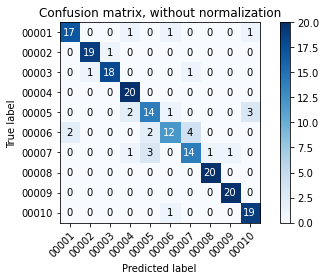

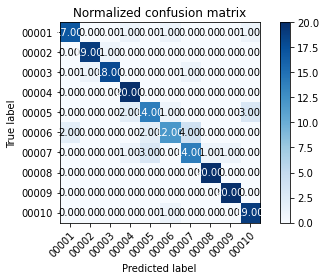

Classification report

               precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.95      0.95      0.95        20
           2       0.95      0.90      0.92        20
           3       0.83      1.00      0.91        20
           4       0.74      0.70      0.72        20
           5       0.80      0.60      0.69        20
           6       0.74      0.70      0.72        20
           7       0.95      1.00      0.98        20
           8       0.95      1.00      0.98        20
           9       0.83      0.95      0.88        20

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



In [143]:
print('Training...')
Final=Classification(train_freq_df_SIFT,test_freq_df_SIFT,train_freq_df_ORB,test_freq_df_ORB)

#Examples of correctly and incorrectly labeled data

Image:


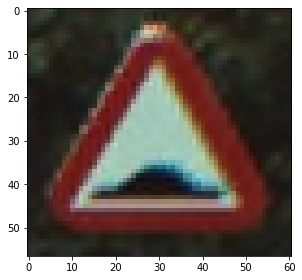

True Label: 1
Predicted Label: 1


In [144]:
print('Image:')
show(Final.Path[0])
print('True Label:',Final.True_L[0])
print('Predicted Label:',Final.Predicted[0])

Image:


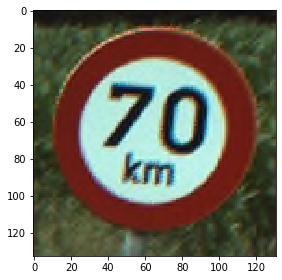

True Label: 2
Predicted Label: 2


In [145]:
print('Image:')
show(Final.Path[25])
print('True Label:',Final.True_L[25])
print('Predicted Label:',Final.Predicted[25])

Image:


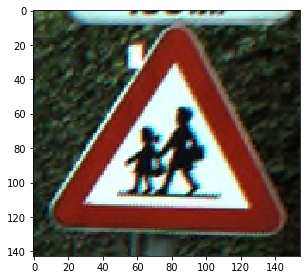

True Label: 4
Predicted Label: 4


In [146]:
print('Image:')
show(Final.Path[75])
print('True Label:',Final.True_L[75])
print('Predicted Label:',Final.Predicted[75])

Image:


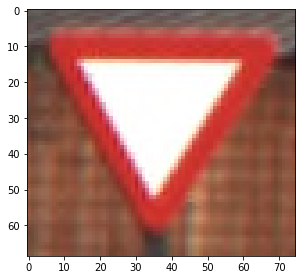

True Label: 6
Predicted Label: 7


In [147]:
print('Image:')
show(Final.Path[107])
print('True Label:',Final.True_L[107])
print('Predicted Label:',Final.Predicted[107])

Image:


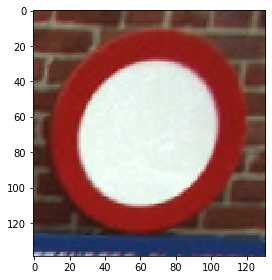

True Label: 7
Predicted Label: 9


In [155]:
print('Image:')
show(Final.Path[124])
print('True Label:',Final.True_L[124])
print('Predicted Label:',Final.Predicted[124])